_This notebook is part of the material for the [Active Training Course "Advanced Deep Learning"](https://indico.desy.de/event/37478/)_

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramonpeter/ErUMData-2023/blob/main/tutorial1_diffusion.ipynb)

## Generating LHC data with Diffusion Models

#### Background

Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful. The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$

#### Outline

- Imports
- Loading the data
- Loading the data
- Preprocessing
- Defining the diffusion model
- Training the model
- Study the results
- Visualizing the diffusion process

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import animation
from IPython.display import HTML
# datapath when not using COLAB
path = "datasets/"

### Loading the data

In [ ]:
# ONLY when using Colab, execute the following lines
!wget -O ErUMData.zip https://www.dropbox.com/scl/fi/gvmelw7u619moo8nyg3j7/ErUMData.zip?rlkey=kq4do1fmalppjt2v24lzau4li&dl=1
!unzip -q ErUMData.zip 
!rm ErUMData.zip
path = ""

In [2]:
train_data = np.load(f"{path}dy_trn_data.npy")
val_data = np.load(f"{path}dy_val_data.npy")
test_data = np.load(f"{path}dy_tst_data.npy")

In [3]:
train_data.shape, val_data.shape, test_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

### Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [4]:
def get_obs(events):
    muon1_4m = events[...,0:4]
    muon2_4m = events[...,4:]
    event_4m = muon1_4m + muon2_4m
    
    event_im = np.sqrt(event_4m[...,0]**2 - event_4m[...,1]**2 - event_4m[...,2]**2 - event_4m[...,3]**2)
    
    event_pt = np.sqrt(event_4m[...,1]**2 + event_4m[...,2]**2)
    muon1_pt = np.sqrt(muon1_4m[...,1]**2 + muon1_4m[...,2]**2)
    muon2_pt = np.sqrt(muon2_4m[...,1]**2 + muon2_4m[...,2]**2)
    
    return event_im, event_pt, muon1_pt, muon2_pt

Now test it for the first two events in the training data:

In [5]:
get_obs(train_data[0:2])

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum. For the same reason, the $p_T$ of the first and second muon are equal.

Let's get the observables for the whole test dataset:

In [6]:
test_event_ims, test_event_pts, test_muon1_pts, test_muon2_pts = get_obs(test_data)

Let's plot the invariant mass of the events:

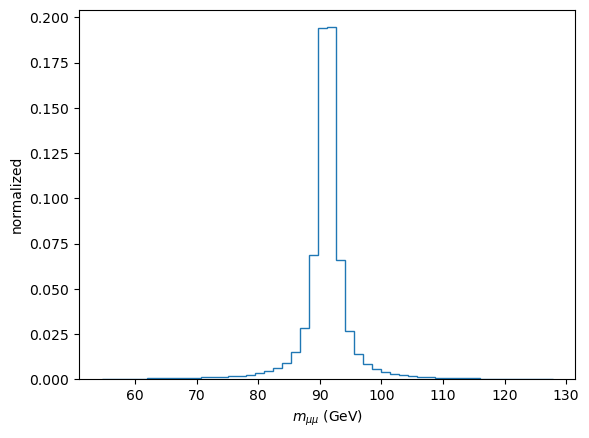

In [7]:
fig, axs = plt.subplots()
axs.hist(test_event_ims, density=True, bins=50, histtype="step")
axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
plt.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV. Now let's look at $p_T$ distributions:

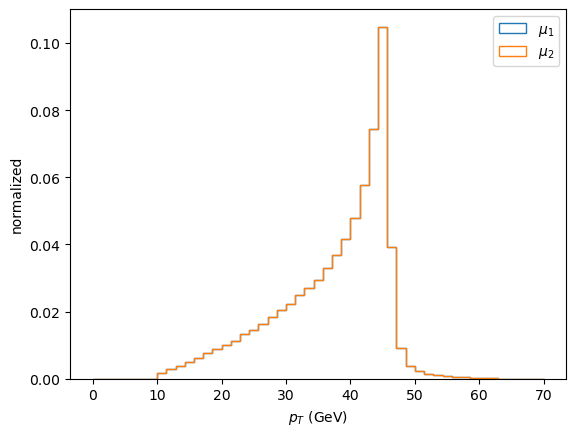

In [8]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(test_muon1_pts, density=True, bins=bins, histtype="step", label=r"$\mu_1$")
axs.hist(test_muon2_pts, density=True, bins=bins, histtype="step", label=r"$\mu_2$")

axs.set_xlabel("$p_{T}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

These distributions are completely overlapping with a peak near $m_Z/2$.

In the collider the incoming particles have no momentum in the $x$ or $y$ directions, therefore momentum conservation means that the final state should also not have any momentum in these directions.  This means that we have redundant degrees of freedom that can be removed from the data.

We can check this:

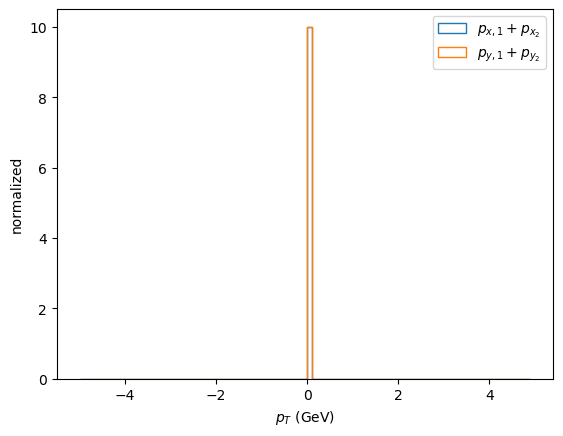

In [9]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(test_data[:,1]+test_data[:,5], density=True, bins=bins, histtype="step", label="$p_{x,1}+p_{x_2}$")
axs.hist(test_data[:,2]+test_data[:,6], density=True, bins=bins, histtype="step", label="$p_{y,1}+p_{y_2}$")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

Muons have a mass of about $106$ MeV.  This is much smaller than the typical energy scales involved in the Drell-Yan process we are studying, so we can assume to a good approximation that the mass of the final state particles are zero.  These final state particles are on-shell, i.e. $p^2=m^2=0$, so we can also use this as a constraint.  We can check that this approximately holds:

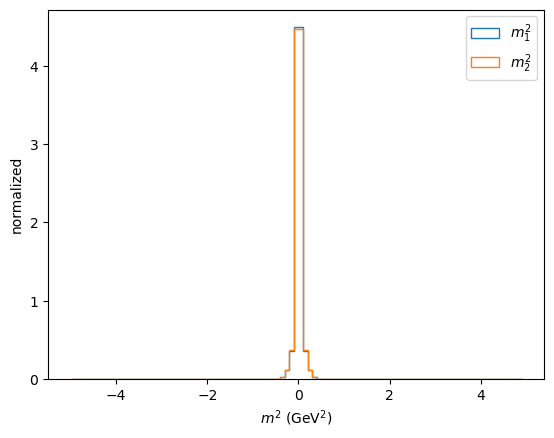

In [10]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(test_data[:,0]**2-test_data[:,1]**2-test_data[:,2]**2-test_data[:,3]**2, 
         density=True, bins=bins, label="$m_1^2$", histtype="step")
axs.hist(test_data[:,4]**2-test_data[:,5]**2-test_data[:,6]**2-test_data[:,7]**2, 
         density=True, bins=bins, label="$m_2^2$", histtype="step")

axs.set_xlabel("$m^2$ (GeV$^2$)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

We can remove 4 degrees of freedom from the data. For the remaining 4 degrees of freedom, we can choose a more suitable representation that takes into account the symmetries of our data:
- $p_T = \sqrt{p_{x,1}^2+p_{y,1}^2}$
- $\eta_1 = \text{arctanh}\left(\frac{p_{z,1}}{\sqrt{p_{x,1}^2+p_{y,1}^2+p_{z,1}^2}}\right)$
- $\eta_2 = \text{arctanh}\left(\frac{p_{z,2}}{\sqrt{p_{x,2}^2+p_{y,2}^2+p_{z,2}^2}}\right)$
- $\phi = \text{arctan2}(p_{y,1}, p_{x,1})$

### Preprocessing

For data to work well with generative models operating on a Gaussian latent space (a typical choice for diffusion models or normalizing flows), we should avoid sharp edges in the input data. We know that $\phi$ follows a uniform distribution, so we can transform it into something closer to a gaussion by applying $\text{arctanh}$. We also apply a component-wise normalization step such that the data has a mean of $0$ and a standard deviation of $1$.

Let's write some functions to apply the preprocessing to the training data and invert it for the generated data:

In [11]:
def apply_preprocessing(data_full):
    pt = np.sqrt(data_full[...,1]**2 + data_full[...,2]**2)
    eta1 = np.arctanh(data_full[...,3] / np.sqrt(data_full[...,1]**2 + data_full[...,2]**2 + data_full[...,3]**2))
    eta2 = np.arctanh(data_full[...,7] / np.sqrt(data_full[...,5]**2 + data_full[...,6]**2 + data_full[...,7]**2))
    phi1 = np.arctanh(np.arctan2(data_full[...,2], data_full[...,1]) / np.pi)
    return np.stack((pt, eta1, eta2, phi1), axis=-1)
    
def invert_preprocessing(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.arctan(data_red[...,3]) * np.pi
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

Now we can apply them to the training data and create a torch Dataset and DataLoader:

In [12]:
train_data_preproc = apply_preprocessing(train_data)
train_mean = np.mean(train_data_preproc, axis=0)
train_std = np.std(train_data_preproc, axis=0)
train_data_normalized = torch.tensor((train_data_preproc - train_mean) / train_std)
train_dataset = TensorDataset(train_data_normalized)
train_dataloader = DataLoader(train_data_normalized, batch_size=10000, shuffle=True)

Let's take a look at the data the generative model has to learn:

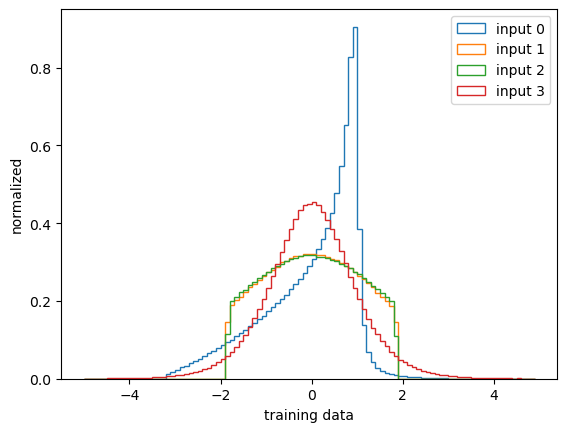

In [13]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
for i in range(4):
    axs.hist(train_data_normalized[:, i].numpy(), density=True, bins=bins, label=f"input {i}", histtype="step")

axs.set_xlabel("training data")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

### Defining the diffusion model

In [14]:
class JetDiffusion(nn.Module):
    def __init__(
        self,
        data_dim: int,     # number of features in the data
        n_steps: int,      # number of time steps
        n_layers: int,     # number of network layers
        hidden_dim: int,   # number of hidden layer nodes
        beta_schedule: str # which schedule to use for the diffusion, "linear" or "cosine"
    ):
        super().__init__()
        self.data_dim = data_dim
        self.n_steps = n_steps

        # Initialize alpha, beta and sigma constants for the given number of time steps
        if beta_schedule == "linear":
            self.betas = self.linear_beta_schedule(n_steps)
        elif beta_schedule == "cosine":
            self.betas = self.cosine_beta_schedule(n_steps)
        else:
            raise ValueError("Unknown schedule")
        alphas = 1 - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.)
        self.one_minus_alphas_bar = 1 - alphas_bar
        self.sqrt_alphas = torch.sqrt(alphas)
        self.sqrt_alphas_bar = torch.sqrt(alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(self.one_minus_alphas_bar)
        self.sigmas = torch.sqrt(self.betas)

        # Build network
        layers = []
        layer_dim_in = data_dim + 1
        for i in range(n_layers - 1):
            layers.append(nn.Linear(layer_dim_in, hidden_dim))
            layers.append(nn.ReLU())
            layer_dim_in = hidden_dim
        layers.append(nn.Linear(layer_dim_in, data_dim))
        torch.nn.init.zeros_(layers[-1].weight)
        torch.nn.init.zeros_(layers[-1].bias)
        self.net = nn.Sequential(*layers)

    def linear_beta_schedule(
        self,
        n_steps: int   # number of time steps
    ) -> torch.Tensor: # beta values at the time steps, shape (n_steps, )
        scale = 1000 / n_steps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, n_steps, dtype=torch.float64)

    def cosine_beta_schedule(
        self,
        n_steps: int,    # number of time steps
        s: float = 0.008 # offset preventing small beta near t = 0
    ) -> torch.Tensor:   # beta values at the time steps, shape (n_steps, )
        x = torch.linspace(0, n_steps, n_steps+1, dtype = torch.float64)
        alphas_cumprod = torch.cos(((x / n_steps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)

    def compute_xt(
        self,
        x0: torch.Tensor,    # data point x_0, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # noisy point x_t, shape (n_batch, data_dim)
        return self.sqrt_alphas_bar[t] * x0 + self.sqrt_one_minus_alphas_bar[t] * noise

    def compute_relative_factor(
        self,
        t: torch.Tensor, # time step, shape (n_batch, 1)
    ) -> torch.Tensor:   # prefactor inside the MSE loss, shape (n_batch, 1)
        return self.betas[t] / (np.sqrt(2) * self.sigmas[t] * self.sqrt_alphas[t] * self.sqrt_one_minus_alphas_bar[t])

    def compute_mu_tilde_t(
        self,
        xt: torch.Tensor,    # noisy point x_t, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # computes mu_tilde_t, shape (n_batch, data_dim)
        return (xt - noise * self.betas[t] / self.sqrt_one_minus_alphas_bar[t]) / self.sqrt_alphas[t]

    def batch_loss(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # loss, shape (n_batch, )
        t = torch.randint(low=1, high=self.n_steps, size=(x.shape[0], 1))
        noise = torch.randn_like(x)
        xt = self.compute_xt(x, t, noise)
        c = self.compute_relative_factor(t)
        model_pred = self.net(torch.cat((xt.float(), t.float()), dim=1))
        return F.mse_loss(c * model_pred, c * noise)

    def sample(
        self,
        n_samples: int,        # number of samples
        keep_xt: bool = False, # whether to keep the intermediate x_t
    ) -> torch.Tensor:         # sampled data, shape (n_samples, data_dim) or (n_steps, n_samples, data_dim)
        x = torch.randn(n_samples, self.data_dim)
        if keep_xt:
            xts = torch.zeros((n_samples, self.n_steps + 1, self.data_dim))
            xts[:, self.n_steps] = x
        for t in reversed(range(self.n_steps)):
            z = torch.randn(n_samples, self.data_dim) if t > 0 else 0.
            model_pred = self.net(torch.cat((x, torch.full((x.shape[0], 1), t, dtype=torch.float32)), dim=1))
            x = self.compute_mu_tilde_t(x, t, model_pred) + self.sigmas[t] * z
            if keep_xt:
                xts[:, t] = x
        return xts if keep_xt else x

### Training the model

In [15]:
jet_diffusion = JetDiffusion(
    data_dim = 4,
    n_steps = 100,
    n_layers = 3,
    hidden_dim = 64,
    beta_schedule = "linear",
)
epochs = 50

optimizer = torch.optim.Adam(jet_diffusion.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_dataloader), epochs=epochs)

losses = np.zeros(epochs)
for epoch in range(epochs):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = jet_diffusion.batch_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_losses.append(loss.item())
    epoch_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}: loss = {epoch_loss}")
    losses[epoch] = epoch_loss

Epoch 1: loss = 0.08648091832199703
Epoch 2: loss = 0.08552105187339074
Epoch 3: loss = 0.08320160938811354
Epoch 4: loss = 0.0769727912272602
Epoch 5: loss = 0.06344552882090157
Epoch 6: loss = 0.04342540306179388
Epoch 7: loss = 0.03055660991817385
Epoch 8: loss = 0.027632602321102494
Epoch 9: loss = 0.02725703400655668
Epoch 10: loss = 0.026878602769979075
Epoch 11: loss = 0.02658632147337181
Epoch 12: loss = 0.026405433925677645
Epoch 13: loss = 0.026098366727785333
Epoch 14: loss = 0.025869340366855207
Epoch 15: loss = 0.025656359455307073
Epoch 16: loss = 0.025553084934132254
Epoch 17: loss = 0.02533681096789682
Epoch 18: loss = 0.025220886181088684
Epoch 19: loss = 0.025040702686253354
Epoch 20: loss = 0.025067417490918696
Epoch 21: loss = 0.024813043302240354
Epoch 22: loss = 0.024894705360806447
Epoch 23: loss = 0.024793769552601503
Epoch 24: loss = 0.02468483652212736
Epoch 25: loss = 0.024719822611928833
Epoch 26: loss = 0.02470900110625099
Epoch 27: loss = 0.024702753592073

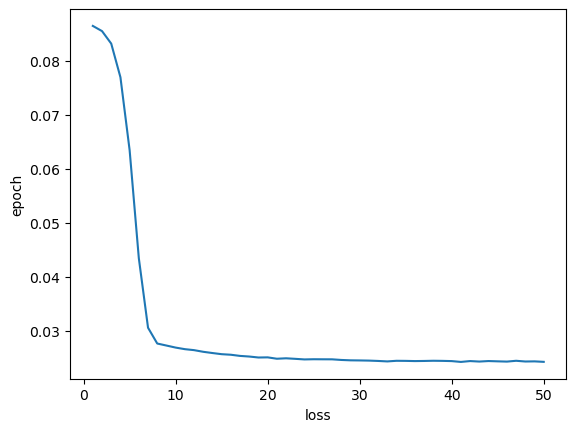

In [16]:
fig, axs = plt.subplots()
axs.plot(np.arange(1, epochs+1), losses)
axs.set_xlabel("loss")
axs.set_ylabel("epoch")
plt.show()

### Study the results

Let's generate some samples, invert the preprocessing and compute the observables from above:

In [17]:
with torch.no_grad():
    sample = jet_diffusion.sample(10000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, _, gen_pt, _ = get_obs(sample_pp)

We can now plot some observables and compare them to the truth distribution. We start with the energy of the first muon.

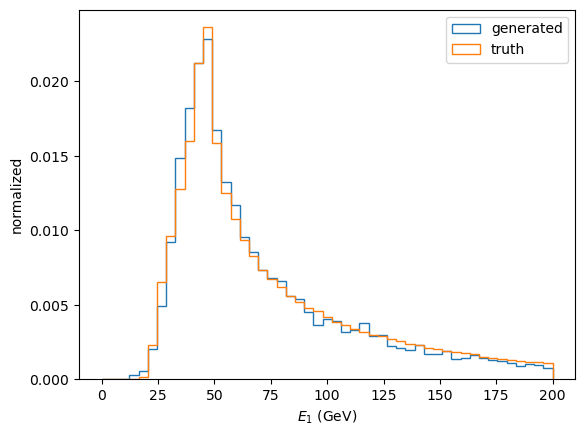

In [18]:
fig, axs = plt.subplots()

bins = np.linspace(0,200,50)
axs.hist(sample_pp[:,0], bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_data[:,0], bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$E_1$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

That looks quite nice! Next, we look at the $p_T$ again.

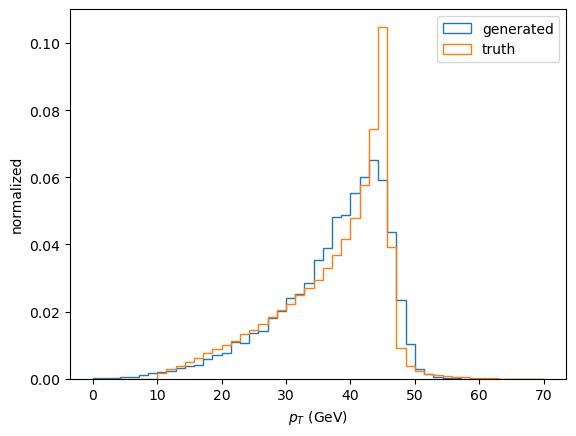

In [19]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(gen_pt, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_muon1_pts, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

We can see that it is difficult for the network to learn the sharp edge near $m_Z$. Learning such features is a typical difficulty of generative networks. Finally, we can take a look at $m_{\mu\mu}$. This observable is challenging to learn because the network needs to extract the correlation between different features correctly.

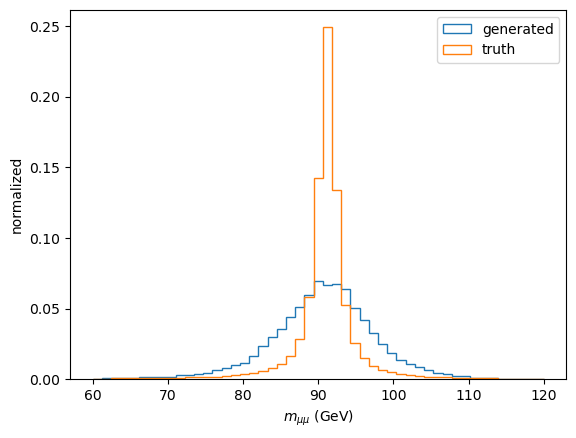

In [20]:
fig, axs = plt.subplots()

bins = np.linspace(60, 120, 50)
axs.hist(gen_event_im, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_event_ims, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

### Visualizing the diffusion process

To get a better intuition of the diffusion process, we can animate it for an observable of our choice. For that, we save the intermediate state of the diffusion at every time step.

In [21]:
with torch.no_grad():
    sample_xt = jet_diffusion.sample(100000, keep_xt=True).cpu().numpy()
sample_ppt = invert_preprocessing(sample_xt * train_std + train_mean)
gen_event_im, _, gen_pt, _ = get_obs(sample_ppt)

Now we can use the FuncAnimation class to make an animated plot:

In [ ]:
test_observable = test_event_ims
gen_observable = gen_event_im

bins = np.linspace(20,160,50)
test_hist, _ = np.histogram(test_observable, bins=bins, density=True)

fig, ax = plt.subplots()
gen_stairs = ax.stairs(test_hist, edges=bins, label="generated")
ax.stairs(test_hist, edges=bins, label="truth")
ax.set_xlabel("$m_{\mu\mu}$ (GeV)")
ax.set_ylabel("normalized")

def draw_frame(t):
    gen_hist, _ = np.histogram(gen_observable[:, -1 - t], bins=bins, density=True)
    gen_stairs.set_data(values=gen_hist, edges=bins)
    return (gen_stairs, )

anim = animation.FuncAnimation(fig, draw_frame, frames=sample_ppt.shape[1], interval=20, blit=True)
plt.close()
HTML(anim.to_jshtml())